
--- Plotting Results for Top 3 Questions by Multiplier ---

Rank 1: Question 28 (Multiplier: 2.96x)
  Min Correct Chain (idx 3): 5.062 tokens
  Max Incorrect Chain (idx 5): 20.064 tokens
  Difference: 15.001999999999999 tokens
  Correct Answer: 104
  Plot saved as plots/r1_sc64_aime_q28_token_diff.png


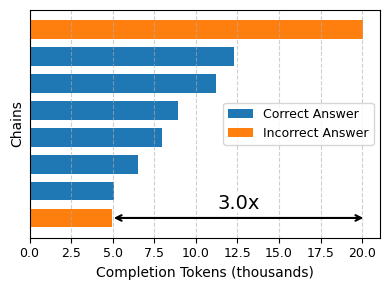


Rank 2: Question 27 (Multiplier: 2.01x)
  Min Correct Chain (idx 6): 7.28 tokens
  Max Incorrect Chain (idx 3): 21.906 tokens
  Difference: 14.625999999999998 tokens
  Correct Answer: 127


  Plot saved as plots/r1_sc64_aime_q27_token_diff.png


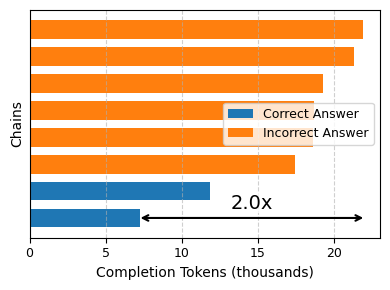


Rank 3: Question 29 (Multiplier: 2.00x)
  Min Correct Chain (idx 1): 6.598 tokens
  Max Incorrect Chain (idx 3): 19.781 tokens
  Difference: 13.183 tokens
  Correct Answer: 104
  Plot saved as plots/r1_sc64_aime_q29_token_diff.png


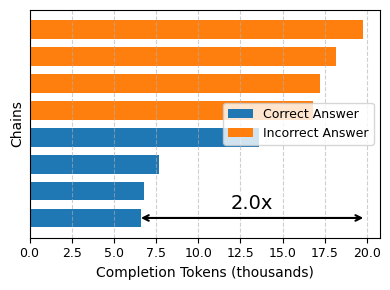

In [2]:
# Import necessary libraries
import os
import json
from pathlib import Path
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Patch # Import Patch for legend

# Set up plotting environment
# %matplotlib inline # This is for Jupyter, comment out for plain Python script execution
# %config InlineBackend.figure_format = 'retina' # For higher resolution plots in Jupyter
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.tab10.colors) # Global, but we'll specify bar colors

# Define base path
user = os.environ.get("USER", "default_user")
BASE_RESULTS_PATH = Path(f"/home/users/ntu/{user}/slimsc/prune/results")

# Define the specific directory containing the summaries
summary_dir = BASE_RESULTS_PATH / "R1-Distill-Qwen-14B/aime/sc_8_control/summaries/"

# --- Step 1: Find the top N questions with the largest multiplier ---
N_TOP_GRAPHS = 3
top_questions_info = [] # To store info for the top N questions

summary_files = sorted(summary_dir.glob('question_*.json'),
                       key=lambda x: int(x.stem.split('_')[1]) if x.stem.split('_')[0] == 'question' and len(x.stem.split('_')) > 1 and x.stem.split('_')[1].isdigit() else float('inf'))

# print(f"Searching through {len(summary_files)} summary files in {summary_dir}")

if not summary_files:
    print(f"No summary files found in {summary_dir}. Please check the path.")
else:
    for file_path in summary_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)

            correct_answer = str(data.get('correct_answer_letter', ''))

            question_match = file_path.stem.split('_')
            question_number = None
            if len(question_match) > 1 and question_match[0] == 'question' and question_match[1].isdigit():
                 question_number = int(question_match[1])
            else:
                # print(f"Skipping file with unexpected name format: {file_path.name}") # Optional: reduce verbosity
                continue

            if 'chains_for_voting_details' in data and data['chains_for_voting_details']:
                chains_data_from_json = data['chains_for_voting_details']

                correct_chains = []
                incorrect_chains = []
                processed_chains_for_this_question = []

                for chain_detail in chains_data_from_json:
                    if 'chain_index' in chain_detail and 'completion_tokens' in chain_detail and 'extracted_answer' in chain_detail:
                        extracted_answer_str = str(chain_detail['extracted_answer'])
                        is_correct_flag = (extracted_answer_str == correct_answer)

                        chain_info = {
                            'chain_index': chain_detail['chain_index'],
                            'completion_tokens': chain_detail['completion_tokens']/1000,
                            'is_correct': is_correct_flag,
                            'extracted_answer': extracted_answer_str
                        }
                        processed_chains_for_this_question.append(chain_info)

                        if is_correct_flag:
                            correct_chains.append(chain_info)
                        else:
                            incorrect_chains.append(chain_info)
                    # else: # Optional: reduce verbosity
                         # print(f"Warning: Skipping chain in {file_path.name} due to missing keys.")

                if correct_chains and incorrect_chains:
                    min_correct_chain = min(correct_chains, key=lambda x: x['completion_tokens'])
                    max_incorrect_chain = max(incorrect_chains, key=lambda x: x['completion_tokens'])
                    
                    min_correct_tokens = min_correct_chain['completion_tokens']
                    max_incorrect_tokens = max_incorrect_chain['completion_tokens']
                    current_difference = max_incorrect_tokens - min_correct_tokens

                    current_multiplier = 0.0 # Default for undefined cases like 0/0
                    if min_correct_tokens > 0:
                        current_multiplier = current_difference / min_correct_tokens
                    elif min_correct_tokens == 0:
                        if current_difference > 0: # e.g. min_correct=0, max_incorrect=100
                            current_multiplier = float('inf')
                        # if current_difference == 0 (min_correct=0, max_incorrect=0), multiplier remains 0.0
                        # if current_difference < 0 (e.g. min_correct=0, max_incorrect=-5), this is impossible for tokens.

                    question_data_for_ranking = {
                        "question_number": question_number,
                        "correct_answer": correct_answer,
                        "min_correct_chain": min_correct_chain,
                        "max_incorrect_chain": max_incorrect_chain,
                        "difference": current_difference,
                        "multiplier": current_multiplier, # Used for sorting
                        "all_chains_data_for_plot": processed_chains_for_this_question
                    }
                    
                    top_questions_info.append(question_data_for_ranking)
                    # Sort by multiplier in descending order
                    top_questions_info.sort(key=lambda x: x['multiplier'], reverse=True)
                    # Keep only top N
                    if len(top_questions_info) > N_TOP_GRAPHS:
                        top_questions_info = top_questions_info[:N_TOP_GRAPHS]

        except json.JSONDecodeError:
            print(f"Error decoding JSON from file: {file_path}")
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"An unexpected error occurred while processing {file_path}: {e}")


# --- Step 2: Plot the results for the top N questions ---

if top_questions_info:
    print(f"\n--- Plotting Results for Top {len(top_questions_info)} Questions by Multiplier ---")
    
    # Create 'plots' directory if it doesn't exist
    output_plot_dir = Path("plots")
    output_plot_dir.mkdir(parents=True, exist_ok=True)

    for i, question_info in enumerate(top_questions_info):
        rank = i + 1
        print(f"\nRank {rank}: Question {question_info['question_number']} (Multiplier: {question_info['multiplier'] if question_info['multiplier'] == float('inf') else f'{question_info['multiplier']:.2f}x'})")
        print(f"  Min Correct Chain (idx {question_info['min_correct_chain']['chain_index']}): {question_info['min_correct_chain']['completion_tokens']:,} tokens")
        print(f"  Max Incorrect Chain (idx {question_info['max_incorrect_chain']['chain_index']}): {question_info['max_incorrect_chain']['completion_tokens']:,} tokens")
        print(f"  Difference: {question_info['difference']:,} tokens")
        print(f"  Correct Answer: {question_info['correct_answer']}")

        if not question_info['all_chains_data_for_plot']:
            print(f"  Skipping plot for Q{question_info['question_number']} due to no chain data for plotting.")
            continue

        plot_df = pd.DataFrame(question_info['all_chains_data_for_plot'])
        plot_df = plot_df.sort_values(by='completion_tokens', ascending=True).reset_index(drop=True)

        color_correct = cm.tab10.colors[0]  # Blue
        color_incorrect = cm.tab10.colors[1] # Orange
        bar_colors = plot_df['is_correct'].apply(lambda x: color_correct if x else color_incorrect).tolist()

        fig, ax = plt.subplots(figsize=(4, 3)) # Adjusted figure size
        
        y_positions = np.arange(len(plot_df))
        bars = ax.barh(y_positions, plot_df['completion_tokens'], color=bar_colors, height=0.7)

        # Use chain index as y-axis tick labels
        ax.set_yticks(y_positions)
        ax.set_yticklabels(plot_df['chain_index'].astype(str), fontsize=9)
        ax.set_ylabel("Chains", fontsize=10) # Add Y-axis label
        ax.set_yticks([])
        
        ax.set_xlabel("Completion Tokens (thousands)", fontsize=10)
        ax.tick_params(axis='x', labelsize=9) # Use ax.tick_params for x-axis too

        # Calculate multiplier text for the plot
        min_correct_tokens_plot = question_info['min_correct_chain']['completion_tokens']
        difference_plot = question_info['difference']
        
        if min_correct_tokens_plot == 0:
            if difference_plot == 0: # 0/0 case
                multiplier_text_plot = "NaN"
            else: # X/0 where X > 0
                multiplier_text_plot = "Inf"
        else:
            actual_multiplier_val = difference_plot / min_correct_tokens_plot
            multiplier_text_plot = f"{actual_multiplier_val:.1f}x"
        
        # Optional: Title for the plot
        # title_text = (f"Rank {rank}: Q{question_info['question_number']} (Multiplier: {multiplier_text_plot})\n"
        #               f"SC N=64 AIME - R1-Distill_Qwen-14B")
        # ax.set_title(title_text, fontsize=9)

        ax.grid(axis='x', linestyle='--', alpha=0.6)

        # --- Add horizontal double-headed arrow ---
        x_start_arrow = question_info['min_correct_chain']['completion_tokens']
        x_end_arrow = question_info['max_incorrect_chain']['completion_tokens']
        
        # Position arrow related to the overall shortest bar
        y_arrow_line = y_positions[0] # y-level of the shortest bar in the plot

        # Draw the double-headed arrow
        # Ensure arrow is drawn only if difference is not zero to avoid zero-length arrow issues
        if x_start_arrow != x_end_arrow :
            ax.annotate('', 
                        xy=(x_start_arrow, y_arrow_line), 
                        xytext=(x_end_arrow, y_arrow_line),
                        arrowprops=dict(arrowstyle='<->', color='black', lw=1.5, shrinkA=0, shrinkB=0),
                        annotation_clip=False)

            # Add text for the multiplier near the arrow
            text_x_pos = (x_start_arrow + x_end_arrow) / 2
            text_y_offset = 0.2 
            text_y_pos = y_arrow_line + text_y_offset 
            
            ax.text(text_x_pos, 
                    text_y_pos, 
                    multiplier_text_plot,
                    ha='center', 
                    va='bottom', 
                    fontsize=14, 
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.75, edgecolor='none', pad=0.1))

        legend_elements = [Patch(facecolor=color_correct, label='Correct Answer'),
                           Patch(facecolor=color_incorrect, label='Incorrect Answer')]
        ax.legend(handles=legend_elements, loc='center right', fontsize=9)

        plt.tight_layout()
        # if title_text: # If title is used
        #    plt.subplots_adjust(top=0.88) # Adjust top margin for title
        
        plot_filename = output_plot_dir / f"r1_sc64_aime_q{question_info['question_number']}_token_diff.png"
        plt.savefig(plot_filename, dpi=300)
        print(f"  Plot saved as {plot_filename}")
        
        plt.show() # Display the plot
        plt.close(fig) # Close the figure to free memory

else:
    print("\nNo suitable questions found with both correct and incorrect chains to calculate multipliers.")
    print("Please check the directory path, the content of the JSON files, and ensure questions have data.")